In [1]:
!pip install geopandas --user -q
!pip install palettable --user -q

In [2]:
from overlay import analysis, layers, boundaries, constants, ipython_widgets, utils

%matplotlib inline

In [3]:
utils.overlay_geopyspark_conf()

In [4]:
study_area_selector = ipython_widgets.boundary_input()

houston boundary file can be found at: 
/home/hadoop/notebooks/data/write/boundaries/houston_msa.shp


Overlay context
>> Defining study area boundaries...
>> Setting geonotebook view extent...
Data preparation
>> Flood hazard dataset already exists for this study area
>> Sea level rise dataset has already been downloaded for this study area
>> Storm surge tiffs have already been created for this study area
Analysis
>> Building layers...
>> Combining layers...
>> Combined 3 layers into climate risk surface
Add to map
>> Creating pyramid layer...
>> Getting layer histogram...
>> Removing existing layers from map...
>> Adding weighted overlay layer to map...


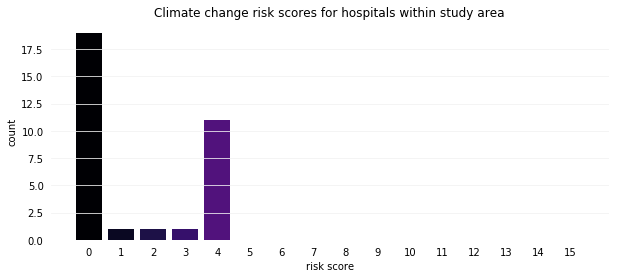

In [5]:
overlay_input_selector = ipython_widgets.overlay_input(M)